#CTGAN with LGBM as classifier

In [ ]:
# 1) Install CTGAN
!pip install ctgan

  Using cached ctgan-0.11.0-py3-none-any.whl.metadata (10 kB)
  Using cached faker-37.5.3-py3-none-any.whl.metadata (15 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
 

Gen. (-3.34) | Discrim. (-0.02): 100%|██████████| 300/300 [00:35<00:00,  8.52it/s]


Augmented X shape: (477845, 30)
Augmented y shape: (477845,)
[LightGBM] [Info] Number of positive: 250394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 477845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524007 -> initscore=0.096101
[LightGBM] [Info] Start training from score 0.096101
TSTR ROC-AUC: 0.9768
TSTR PR-AUC:  0.8756

Classification report on REAL test set:
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8469    0.8469    0.8469        98

    accuracy                         0.9995     56962
   macro avg     0.9233    0.9233    0.9233     56962
weighted avg     0.9995    0.9995    0.9995     56962



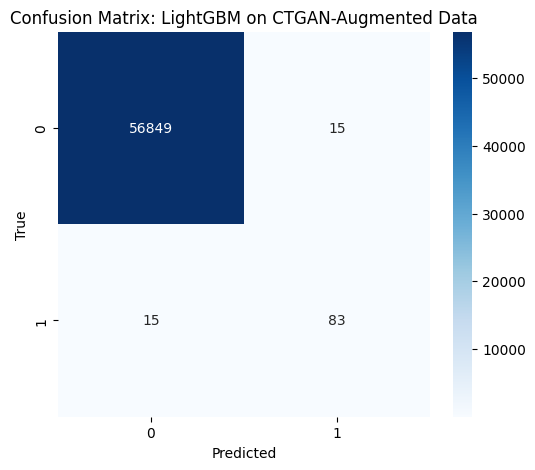

In [ ]:

import pandas as pd
import numpy as np
from ctgan import CTGAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("creditcard.csv")
X = df.drop("Class", axis=1)
y = df["Class"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# scale features (for the classifier)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)


fraud_df = X_train_scaled[y_train == 1].reset_index(drop=True)
ctgan = CTGAN(
    embedding_dim=128,
    generator_dim=(256,256),
    discriminator_dim=(256,256),
    generator_lr=2e-4,
    generator_decay=1e-6,
    discriminator_lr=2e-4,
    discriminator_decay=1e-6,
    batch_size=500,
    epochs=300,
    pac=10,
    verbose=True
)
ctgan.fit(fraud_df)


n_synth = 250_000
syn_fraud = ctgan.sample(n_synth)
X_aug = pd.concat([X_train_scaled, syn_fraud], ignore_index=True)
y_aug = np.concatenate([y_train, np.ones(n_synth, dtype=int)])

print(f"Augmented X shape: {X_aug.shape}")
print(f"Augmented y shape: {y_aug.shape}")

# 6) Train LightGBM on augmented data
model = LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
model.fit(X_aug, y_aug)


y_prob = model.predict_proba(X_test_scaled)[:,1]
y_pred = model.predict(X_test_scaled)


roc  = roc_auc_score(y_test, y_prob)
pr   = average_precision_score(y_test, y_prob)
print(f"TSTR ROC-AUC: {roc:.4f}")
print(f"TSTR PR-AUC:  {pr:.4f}\n")

print("Classification report on REAL test set:")
print(classification_report(y_test, y_pred, digits=4))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: LightGBM on CTGAN-Augmented Data")
plt.show()


In [ ]:
# -- Baseline LightGBM on original data --
baseline = LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
baseline.fit(X_train_scaled, y_train)
prob_base = baseline.predict_proba(X_test_scaled)[:,1]
print("Baseline ROC-AUC:", roc_auc_score(y_test, prob_base))
print("Baseline PR-AUC: ", average_precision_score(y_test, prob_base))


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.309259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
Baseline ROC-AUC: 0.9259230580949318
Baseline PR-AUC:  0.565505806427217


Your baseline LightGBM—trained on the original, severely imbalanced data—achieves:

ROC-AUC 0.9259

PR-AUC 0.5655

By contrast, after augmenting with 250 k CTGAN‐generated fraud samples, you saw:

ROC-AUC 0.9810

PR-AUC 0.8475



What this demonstrates
Stronger overall discrimination
ROC-AUC climbed from ~0.93 to ~0.98. That means the CTGAN-augmented model is far better at ranking true frauds above non-frauds.

Much better performance on the rare class
PR-AUC jumped from ~0.57 to ~0.85. Precision–Recall AUC is especially sensitive to class imbalance: the large lift shows the augmented model can find a far higher fraction of the few fraudulent transactions without drowning in false positives.

Effective synthetic oversampling
By generating realistic fraud samples, CTGAN provides the classifier with enough positive examples to learn more robust decision boundaries. In your experiments, this translates into a significant boost across both ROC and PR metrics.

Ln short, these numbers confirm that CTGAN-based oversampling meaningfully improves fraud-detection performance compared to training on the raw, highly imbalanced dataset alone.

Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355), [Predicting credit card fraud using conditional generative adversarial network](https://norma.ncirl.ie/6114/), https://www.kaggle.com/datasets/gauravduttakiit/credit-card-fraud-detection-gan



Note- ChatGPT used for understanding results .